# Exploring Entity Co-occurrence Networks

<a target="_blank" href="https://colab.research.google.com/github/impresso/impresso-datalab-notebooks/4-impresso-py/network_graph.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Install dependencies

In [ ]:
%pip install -q impresso ipysigma networkx tqdm


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Connect to Impresso

In [7]:
from impresso import connect, OR, AND

impresso_session = connect()

🎉 You are now connected to the Impresso API!  🎉


## Part 1: Get entities and their co-occurrences

### First, we retrieve all person entities mentioned in all articles that talk about the [Prague Spring](https://en.wikipedia.org/wiki/Prague_Spring).

In [8]:
query = OR("Prague Spring", "Prager Frühling", "Printemps de Prague")

,count,label
value,,
aida-0001-50-Alexander_Dubček,83,Alexander Dubček
aida-0001-50-Gustáv_Husák,57,Gustáv Husák
aida-0001-50-Ota_Šik,36,Ota Šik

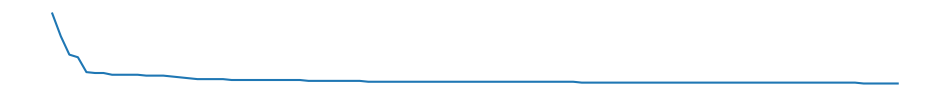

In [9]:
persons = impresso_session.search.facet(
  facet="person",
  term=query,
  order_by="-count",
  limit=100
)
persons

### Next, we generate all unique pairs of entities with a mention count higher than `n`.
 
First, entities that meet the mention threshold are selected, and then all possible pairs are generated using the `itertools.combinations` function.

The `n` value can be adjusted so that we don't get too many entity combinations. A sweet spot is just under 500 combinations.

In [ ]:
import itertools

n = 6

df = persons.df
df = df[df["count"] > n]
persons_ids = df.index.tolist()
print(f"Total persons selected: {len(persons_ids)}")

person_ids_combinations = list(itertools.combinations(persons_ids, 2))
print(f"Total combinations: {len(person_ids_combinations)}")

Total persons selected: 30
Total combinations: 435


In [15]:
if len(person_ids_combinations) > 500:
  msg = (
      f"The number of combinations is quite high ({len(person_ids_combinations)}). " +
      "This may put a lot of load on Impresso and your requests may be throttled. " +
      "Try to increase the threshold number of mentions in the cell above which will reduce the number of selected persons. " +
      "You can also disable this error by commenting out this cell, if this number of combinations is expected."
  )
  raise Exception(msg)


### We also retrieve the dates and the number of articles where person entity pairs appear in.

This piece of code gets a facet for every combination of named entities. It is a single call per combination so it may take a while for a large number of combinations.

In [17]:
from impresso.util.error import ImpressoError
from time import sleep
from tqdm import tqdm

connections = []

# iterate over entity combinations, and build a query from each pair, faceting on `daterange`
# the `query` variable hold the same value as above, i.e. keyword search for articles
for idx, combo in tqdm(enumerate(person_ids_combinations), total=len(person_ids_combinations)):
  try:
    result = impresso_session.search.facet(
      facet="daterange",
      term=query,
      entity_id=AND(*combo),
      limit=1000
    )
  except ImpressoError as e:
    # a 429 status code means that the request has been throttled
    # we sleep for 2 seconds and try again
    if e.error.status == 429:
      print(f"Sleeping because of {e}")
      sleep(2)

  if result.size > 0:
    df = result.df

    items = list(zip(df.index.tolist(), df['count'].tolist(), [result.url for i in range(len(df))]))
    connections.append((combo, items))

100%|██████████| 435/435 [01:09<00:00,  6.28it/s]


We put all in a dataframe

In [19]:
import pandas as pd

connections_denormalised = []
for c in connections:
  nodes, edges = c

  connections_denormalised.extend(
    [[node_a, node_b, ts, count, url] for (node_a, node_b), (ts, count, url) in zip([nodes for i in range(len(edges))], edges)]
  )

connections_df = pd.DataFrame(connections_denormalised, columns=('node_a', 'node_b', 'timestamp', 'count', 'url'))
connections_df

,node_a,node_b,timestamp,count,url
0,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1968-10-02T00:00:00Z,4,https://impresso-project.ch/app/search?index=s...
1,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1969-10-02T00:00:00Z,10,https://impresso-project.ch/app/search?index=s...
2,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1973-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
3,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1974-10-02T00:00:00Z,2,https://impresso-project.ch/app/search?index=s...
4,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1977-10-02T00:00:00Z,2,https://impresso-project.ch/app/search?index=s...
...,...,...,...,...,...
193,aida-0001-50-Miloš_Forman,aida-0001-50-Alessandro_Cagliostro,1975-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
194,aida-0001-50-Miloš_Forman,aida-0001-50-Jean_Marais,1975-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
195,aida-0001-50-Paul_Lendvai,aida-0001-50-Jiří_Hájek,1976-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
196,aida-0001-50-Paul_Lendvai,aida-0001-50-Lubomír_Štrougal,1975-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...


And save the connections to a CSV file that can be visualised independently in Part 2. Provide a name for the file.

In [20]:
from tempfile import gettempdir

temp_dir = gettempdir()

connections_csv_filename = input("Enter the filename: ").replace(" ", "_")
connections_csv_filepath = f"{temp_dir}/{connections_csv_filename}.csv"
connections_df.to_csv(connections_csv_filepath)
print(f"File saved in {connections_csv_filepath}")

File saved in /var/folders/0h/60jp226s7c95z0wq163306fc0000gn/T/my_collection.csv


## Part 2: visualise

In [21]:
import pandas as pd

connections_df = pd.read_csv(connections_csv_filepath)
connections_df

,Unnamed: 0,node_a,node_b,timestamp,count,url
0,0,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1968-10-02T00:00:00Z,4,https://impresso-project.ch/app/search?index=s...
1,1,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1969-10-02T00:00:00Z,10,https://impresso-project.ch/app/search?index=s...
2,2,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1973-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
3,3,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1974-10-02T00:00:00Z,2,https://impresso-project.ch/app/search?index=s...
4,4,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,1977-10-02T00:00:00Z,2,https://impresso-project.ch/app/search?index=s...
...,...,...,...,...,...,...
193,193,aida-0001-50-Miloš_Forman,aida-0001-50-Alessandro_Cagliostro,1975-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
194,194,aida-0001-50-Miloš_Forman,aida-0001-50-Jean_Marais,1975-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
195,195,aida-0001-50-Paul_Lendvai,aida-0001-50-Jiří_Hájek,1976-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
196,196,aida-0001-50-Paul_Lendvai,aida-0001-50-Lubomír_Štrougal,1975-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...


Group connections counting number of mentions and preserve the URL.

In [22]:
grouped_connections_df = connections_df.groupby(['node_a', 'node_b']) \
    .agg({'timestamp': lambda x: ', '.join(list(x)), 'count': 'sum', 'url': lambda x: list(set(x))[0]}) \
    .reset_index()
grouped_connections_df

,node_a,node_b,timestamp,count,url
0,aida-0001-50-Alessandro_Cagliostro,aida-0001-50-Jean_Marais,1975-10-02T00:00:00Z,6,https://impresso-project.ch/app/search?index=s...
1,aida-0001-50-Alexander_Dubček,aida-0001-50-Antonín_Novotný,"1967-10-02T00:00:00Z, 1968-10-02T00:00:00Z, 19...",7,https://impresso-project.ch/app/search?index=s...
2,aida-0001-50-Alexander_Dubček,aida-0001-50-Gustáv_Husák,"1968-10-02T00:00:00Z, 1969-10-02T00:00:00Z, 19...",24,https://impresso-project.ch/app/search?index=s...
3,aida-0001-50-Alexander_Dubček,aida-0001-50-Harold_Wilson,"1968-10-02T00:00:00Z, 1969-10-02T00:00:00Z, 19...",3,https://impresso-project.ch/app/search?index=s...
4,aida-0001-50-Alexander_Dubček,aida-0001-50-Jan_Palach,"1969-10-02T00:00:00Z, 1972-10-02T00:00:00Z, 19...",4,https://impresso-project.ch/app/search?index=s...
...,...,...,...,...,...
101,aida-0001-50-Willy_Brandt,aida-0001-50-Johannes_Brahms,1969-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
102,aida-0001-50-Willy_Brandt,aida-0001-50-Lubomír_Štrougal,1969-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...
103,aida-0001-50-Willy_Brandt,aida-0001-50-Walter_Ulbricht,"1969-10-02T00:00:00Z, 1970-10-02T00:00:00Z",2,https://impresso-project.ch/app/search?index=s...
104,aida-0001-50-Zdeněk_Mlynář,aida-0001-50-Jiří_Pelikán,1977-10-02T00:00:00Z,1,https://impresso-project.ch/app/search?index=s...


In [23]:
import networkx as nx

G = nx.from_pandas_edgelist(
    grouped_connections_df,
    source='node_a',
    target='node_b',
    edge_attr=['count', 'url'],
    create_using=nx.MultiGraph()
)
for i in sorted(G.nodes()):
    G.nodes[i]['url'] = f"https://impresso-project.ch/app/entities/{i}"
G.nodes

NodeView(('aida-0001-50-Alessandro_Cagliostro', 'aida-0001-50-Jean_Marais', 'aida-0001-50-Alexander_Dubček', 'aida-0001-50-Antonín_Novotný', 'aida-0001-50-Gustáv_Husák', 'aida-0001-50-Harold_Wilson', 'aida-0001-50-Jan_Palach', 'aida-0001-50-Jiří_Hájek', 'aida-0001-50-Josef_Smrkovský', 'aida-0001-50-Lubomír_Štrougal', 'aida-0001-50-Ludvík_Svoboda', 'aida-0001-50-Mikhail_Gorbachev', 'aida-0001-50-Miloš_Forman', 'aida-0001-50-Oldřich_Černík', 'aida-0001-50-Ota_Šik', 'aida-0001-50-Pavel_Kohout', 'aida-0001-50-Václav_Havel', 'aida-0001-50-Walter_Ulbricht', 'aida-0001-50-Willy_Brandt', 'aida-0001-50-Zdeněk_Mlynář', 'aida-0001-50-Věra_Chytilová', 'aida-0001-50-Jaromil_Jireš', 'aida-0001-50-Jiří_Menzel', 'aida-0001-50-Paul_Lendvai', 'aida-0001-50-Richard_Nixon', 'aida-0001-50-Herbert_von_Karajan', 'aida-0001-50-Bedřich_Smetana', 'aida-0001-50-Joseph_Haydn', 'aida-0001-50-Johannes_Brahms', 'aida-0001-50-Jiří_Pelikán'))

Save the file so that it could be downloaded and used elsewhere.

In [24]:
from tempfile import gettempdir

temp_dir = gettempdir()

gefx_filename = input("Enter the gefx filename: ").replace(" ", "_")
gefx_filepath = f"{temp_dir}/{gefx_filename}.gefx"

nx.write_gexf(G, gefx_filepath)

print(f"File saved in {gefx_filepath}")

File saved in /var/folders/0h/60jp226s7c95z0wq163306fc0000gn/T/my_gefx.gefx


If running in Colab - activate custom widgets to allow `ipysigma` to render the graph.

In [25]:
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

Render the graph.

In [26]:
import ipywidgets

node_size_widget = ipywidgets.Dropdown(
    options=['Degree', 'Betweenness', 'Eigenvector', 'Closeness'],
    value='Degree',
    disabled=False,
    layout={'width': 'max-content'}
)
ipywidgets.Box(
    [
        ipywidgets.Label(value='What should represent the size of the nodes:'), 
        node_size_widget
    ]
)


Box(children=(Label(value='What should represent the size of the nodes:'), Dropdown(layout=Layout(width='max-c…

Refresh the next cell after changing the value above.

In [27]:
import networkx as nx
from ipysigma import Sigma

# Importing a gexf graph
g = nx.read_gexf(gefx_filepath)

node_size = None
# Read node size method
match node_size_widget.value:
    case 'Degree':
        node_size = g.degree
    case 'Betweenness':
        node_size = nx.betweenness_centrality(g)
    case 'Eigenvector':
        node_size = nx.eigenvector_centrality(g)
    case 'Closeness':
        node_size = nx.closeness_centrality(g)
    case _:
        node_size = g.degree

print(f"Node size method: {node_size_widget.value}.")
print("See the following link for more information about centrality measures: https://networkx.org/documentation/stable/reference/algorithms/centrality.html")

# Displaying the graph with a size mapped on degree and
# a color mapped on a categorical attribute of the nodes
Sigma(g, node_size=node_size, edge_size='count', clickable_edges=True, )

Node size method: Degree.
See the following link for more information about centrality measures: https://networkx.org/documentation/stable/reference/algorithms/centrality.html


Sigma(nx.Graph with 30 nodes and 106 edges)